In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os

from tensorflow.keras.preprocessing import image  # 将图像处理为4D张量形式

# 忽略硬件加速的警告信息
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# 设置图像参数尺寸
target_size = (512, 512, 3)

In [2]:
def path_to_tensor(img_path):
    '''图片格式处理'''
    img = image.load_img(img_path, target_size=target_size)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0).astype('float32')/255
    print(img_tensor.shape)
    return img_tensor

In [3]:
rgb_input = path_to_tensor('./data/RGB/RGB002.jpg')
tir_input = path_to_tensor('./data/TIR/TIR002.jpg')

(1, 512, 512, 3)
(1, 512, 512, 3)


In [4]:
# 卷积
def conv_2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')

# 源码的位置在tensorflow/python/ops下nn_impl.py和nn_ops.py
# 这个函数接收两个参数,x 是图像的像素, w 是卷积核
# x 张量的维度[batch, height, width, channels]
# w 卷积核的维度[height, width, channels, channels_multiplier]
# tf.nn.conv2d()是一个二维卷积函数,
# stirdes 是卷积核移动的步长,4个1表示,在x张量维度的四个参数上移动步长
# padding 参数'SAME',表示对原始输入像素进行填充,卷积后映射的2D图像与原图大小相等
# 填充,是指在原图像素值矩阵周围填充0像素点
# 如果不进行填充,假设 原图为 32x32 的图像,卷积和大小为 5x5 ,卷积后映射图像大小 为 28x28

In [5]:
# 池化
def max_pool_2d(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# 池化跟卷积的情况有点类似
# x 是卷积后,有经过非线性激活后的图像,
# ksize 是池化滑动张量
# ksize 的维度[batch, height, width, channels],跟 x 张量相同
# strides [1, 2, 2, 1],与上面对应维度的移动步长
# padding与卷积函数相同,padding='VALID',对原图像不进行0填充

In [6]:
# 权重初始化(卷积核初始化)
# tf.truncated_normal()不同于tf.random_normal(),返回的值中不会偏离均值两倍的标准差
# 参数shpae为一个列表对象,例如[5, 5, 1, 32]对应
# 5,5 表示卷积核的大小, 1代表通道channel,对彩色图片做卷积是3,单色灰度为1
# 最后一个数字32,卷积核的个数,(也就是卷基层提取的特征数量)
#   显式声明数据类型,切记
def weight_init(shape):
    weights = tf.keras.backend.truncated_normal(shape, stddev=0.1,dtype=tf.float32)
    return tf.Variable(weights)

# 偏置的初始化
def biases_init(shape):
    biases = tf.keras.backend.random_normal(shape,dtype=tf.float32)
    return tf.Variable(biases)

In [7]:
# ---------------------------------RGB图片卷积网络-------------------------------

In [8]:
# 第一层卷积+池化
w_conv1 = weight_init([3, 3, 3, 16])                             # 3x3,深度为1,16个
b_conv1 = biases_init([16])
h_conv1 = tf.nn.relu(conv_2d(rgb_input, w_conv1) + b_conv1)    # 输出张量的尺寸:512x512x16
h_pool1 = max_pool_2d(h_conv1)

# 第二层卷积+池化
w_conv2 = weight_init([3, 3, 16, 32])                             # 3x3,深度为16,32个
b_conv2 = biases_init([32])
h_conv2 = tf.nn.relu(conv_2d(h_pool1, w_conv2) + b_conv2)    # 输出张量的尺寸:256x256x32
h_pool2 = max_pool_2d(h_conv2)

# 第三层卷积+池化
w_conv3 = weight_init([3, 3, 32, 32])                             # 3x3,深度为32,32个
b_conv3 = biases_init([32])
h_conv3 = tf.nn.relu(conv_2d(h_pool2, w_conv3) + b_conv3)    # 输出张量的尺寸:128x128x32
h_pool3 = max_pool_2d(h_conv3)

# 第四层卷积+池化
w_conv4 = weight_init([3, 3, 32, 64])                             # 3x3,深度为32,64个
b_conv4 = biases_init([64])
h_conv4 = tf.nn.relu(conv_2d(h_pool3, w_conv4) + b_conv4)    # 输出张量的尺寸:64x64x64
h_pool4 = max_pool_2d(h_conv4)

# 第五层卷积+池化
w_conv5 = weight_init([3, 3, 64, 64])                             # 3x3,深度为64,64个
b_conv5 = biases_init([64])
h_conv5 = tf.nn.relu(conv_2d(h_pool4, w_conv5) + b_conv5)    # 输出张量的尺寸:32x32x64
h_pool5 = max_pool_2d(h_conv5)

In [9]:
# ---------------------------------各个层特征可视化-------------------------------

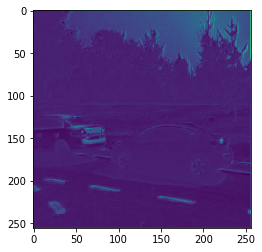

In [10]:
# 第一层的卷积输出的特征图
# conv1_transpose = tf.transpose(h_conv1, [3, 0, 1, 2])
# fig1,ax1 = plt.subplots(nrows=2, ncols=8, figsize = (16,4), sharex='col', sharey='row')
# for j in range(2):
#     for k in range(8):
#         i = j * 8 + k
#         ax1[j][k].imshow(conv1_transpose[i][0])                      # tensor的切片[row, column]
# plt.title('Conv1 16x512x512')
# plt.savefig('./output/rgb-conv1.png', dpi=600)
# plt.show()

# 第一层池化后的特征图
pool1_transpose = tf.transpose(h_pool1, [3, 0, 1, 2])
conv1_feature = np.zeros(pool1_transpose[0][0].shape)
for i in range(16):
    conv1_feature += pool1_transpose[i][0]
conv1_feature /= 16
plt.imshow(conv1_feature)
# fig2,ax2 = plt.subplots(nrows=2, ncols=8, figsize=(16,4), sharex='col', sharey='row')
# for j in range(2):
#     for k in range(8):
#         i = j * 8 + k
#         ax2[j][k].imshow(pool1_transpose[i][0])
# plt.title('Pool1 16x256x256')
# plt.savefig('./output/rgb-pool1.png', dpi=600)
# plt.show()

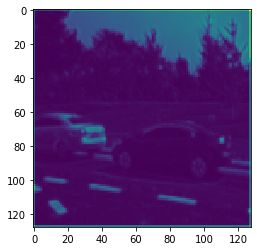

In [11]:
# 第二层卷积输出特征图
# conv2_transpose = tf.transpose(h_conv2, [3, 0, 1, 2])
# fig3,ax3 = plt.subplots(nrows=4, ncols=8, figsize = (16, 8), sharex='col', sharey='row')
# for j in range(4):
#     for k in range(8):
#         i = j * 8 + k
#         ax3[j][k].imshow(conv2_transpose[i][0])
# plt.title('Conv2 32x256x256')
# plt.savefig('./output/rgb-conv2.png', dpi=600)
# plt.show()

# 第二层池化后的特征图
pool2_transpose = tf.transpose(h_pool2, [3, 0, 1, 2])
conv2_feature = np.zeros(pool2_transpose[0][0].shape)
for i in range(32):
    conv2_feature += pool2_transpose[i][0]
conv2_feature /= 32
plt.imshow(conv2_feature)
# fig4,ax4 = plt.subplots(nrows=4, ncols=8, figsize = (16, 8), sharex='col', sharey='row')
# for j in range(4):
#     for k in range(8):
#         i = j * 8 + k
#         ax4[j][k].imshow(pool2_transpose[i][0])
# plt.title('Pool2 32x128x128')
# plt.savefig('./output/rgb-pool2.png', dpi=600)
# plt.show()

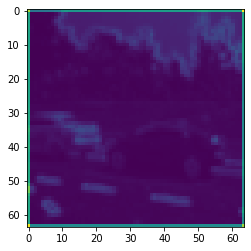

In [12]:
# 第三层卷积输出特征图
# conv3_transpose = tf.transpose(h_conv3, [3, 0, 1, 2])
# fig5,ax5 = plt.subplots(nrows=4, ncols=8, figsize = (16, 8), sharex='col', sharey='row')
# for j in range(4):
#     for k in range(8):
#         i = j * 8 + k
#         ax5[j][k].imshow(conv3_transpose[i][0])
# plt.title('Conv3 32x256x256')
# plt.savefig('./output/rgb-conv3.png', dpi=600)
# plt.show()

# 第三层池化后的特征图
pool3_transpose = tf.transpose(h_pool3, [3, 0, 1, 2])
conv3_feature = np.zeros(pool3_transpose[0][0].shape)
for i in range(32):
    conv3_feature += pool3_transpose[i][0]
conv3_feature /= 32
plt.imshow(conv3_feature)
# fig6,ax6 = plt.subplots(nrows=4, ncols=8, figsize = (16, 8), sharex='col', sharey='row')
# for j in range(4):
#     for k in range(8):
#         i = j * 8 + k
#         ax6[j][k].imshow(pool3_transpose[i][0])
# plt.title('Pool3 32x128x128')
# plt.savefig('./output/rgb-pool3.png', dpi=600)
# plt.show()

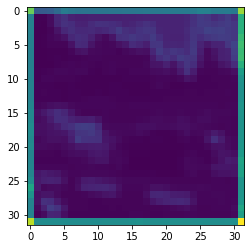

In [13]:
# 第四层卷积输出特征图
# conv4_transpose = tf.transpose(h_conv4, [3, 0, 1, 2])
# fig7,ax7 = plt.subplots(nrows=8, ncols=8, figsize = (16, 16), sharex='col', sharey='row')
# for j in range(8):
#     for k in range(8):
#         i = j * 8 + k
#         ax7[j][k].imshow(conv4_transpose[i][0])
# plt.title('Conv4 64x128x128')
# plt.savefig('./output/rgb-conv4.png', dpi=600)
# plt.show()

# 第四层池化后的特征图
pool4_transpose = tf.transpose(h_pool4, [3, 0, 1, 2])
conv4_feature = np.zeros(pool4_transpose[0][0].shape)
for i in range(64):
    conv4_feature += pool4_transpose[i][0]
conv4_feature /= 64
plt.imshow(conv4_feature)
# fig8,ax8 = plt.subplots(nrows=8, ncols=8, figsize = (16, 16), sharex='col', sharey='row')
# for j in range(8):
#     for k in range(8):
#         i = j * 8 + k
#         ax8[j][k].imshow(pool4_transpose[i][0])
# plt.title('Pool4 64x64x64')
# plt.savefig('./output/rgb-pool4.png', dpi=600)
# plt.show()

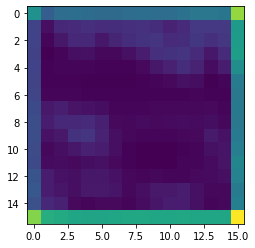

In [14]:
# 第五层卷积输出特征图
# conv5_transpose = tf.transpose(h_conv5, [3, 0, 1, 2])
# fig9,ax9 = plt.subplots(nrows=8, ncols=8, figsize = (16, 16), sharex='col', sharey='row')
# for j in range(8):
#     for k in range(8):
#         i = j * 8 + k
#         ax9[j][k].imshow(conv5_transpose[i][0])
# plt.title('Conv5 64x64x64')
# plt.savefig('./output/rgb-conv5.png', dpi=600)
# plt.show()

# 第五层池化后的特征图
pool5_transpose = tf.transpose(h_pool5, [3, 0, 1, 2])
conv5_feature = np.zeros(pool5_transpose[0][0].shape)
for i in range(64):
    conv5_feature += pool5_transpose[i][0]
conv5_feature /= 64
plt.imshow(conv5_feature)
# fig0,ax0 = plt.subplots(nrows=8, ncols=8, figsize = (16, 16), sharex='col', sharey='row')
# for j in range(8):
#     for k in range(8):
#         i = j * 8 + k
#         ax0[j][k].imshow(pool5_transpose[i][0])
# plt.title('Pool5 64x32x32')
# plt.savefig('./output/rgb-pool5.png', dpi=600)
# plt.show()

In [15]:
# ---------------------------------TIR图片卷积网络-------------------------------

In [16]:
# 第一层卷积+池化
# w_conv1 = weight_init([3, 3, 3, 16])                             # 3x3,深度为1,16个
# b_conv1 = biases_init([16])
h_conv1 = tf.nn.relu(conv_2d(tir_input, w_conv1) + b_conv1)    # 输出张量的尺寸:512x512x16
h_pool1 = max_pool_2d(h_conv1)

# 第二层卷积+池化
# w_conv2 = weight_init([3, 3, 16, 32])                             # 3x3,深度为16,32个
# b_conv2 = biases_init([32])
h_conv2 = tf.nn.relu(conv_2d(h_pool1, w_conv2) + b_conv2)    # 输出张量的尺寸:256x256x32
h_pool2 = max_pool_2d(h_conv2)

# 第三层卷积+池化
# w_conv3 = weight_init([3, 3, 32, 32])                             # 3x3,深度为32,32个
# b_conv3 = biases_init([32])
h_conv3 = tf.nn.relu(conv_2d(h_pool2, w_conv3) + b_conv3)    # 输出张量的尺寸:128x128x32
h_pool3 = max_pool_2d(h_conv3)

# 第四层卷积+池化
# w_conv4 = weight_init([3, 3, 32, 64])                             # 3x3,深度为32,64个
# b_conv4 = biases_init([64])
h_conv4 = tf.nn.relu(conv_2d(h_pool3, w_conv4) + b_conv4)    # 输出张量的尺寸:64x64x64
h_pool4 = max_pool_2d(h_conv4)

# 第五层卷积+池化
# w_conv5 = weight_init([3, 3, 64, 64])                             # 3x3,深度为64,64个
# b_conv5 = biases_init([64])
h_conv5 = tf.nn.relu(conv_2d(h_pool4, w_conv5) + b_conv5)    # 输出张量的尺寸:32x32x64
h_pool5 = max_pool_2d(h_conv5)

In [17]:
# ---------------------------------各个层特征可视化-------------------------------

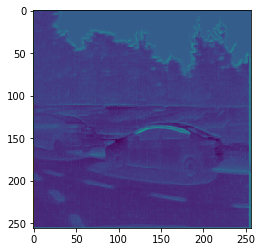

In [18]:
# 第一层的卷积输出的特征图
# conv1_transpose = tf.transpose(h_conv1, [3, 0, 1, 2])
# fig1,ax1 = plt.subplots(nrows=2, ncols=8, figsize = (16,4), sharex='col', sharey='row')
# for j in range(2):
#     for k in range(8):
#         i = j * 8 + k
#         ax1[j][k].imshow(conv1_transpose[i][0])                      # tensor的切片[row, column]
# plt.title('Conv1 16x512x512')
# plt.savefig('./output/tir-conv1.png', dpi=600)
# plt.show()

# 第一层池化后的特征图
pool1_transpose = tf.transpose(h_pool1, [3, 0, 1, 2])
conv1_feature = np.zeros(pool1_transpose[0][0].shape)
for i in range(16):
    conv1_feature += pool1_transpose[i][0]
conv1_feature /= 16
plt.imshow(conv1_feature)
# fig2,ax2 = plt.subplots(nrows=2, ncols=8, figsize=(16,4), sharex='col', sharey='row')
# for j in range(2):
#     for k in range(8):
#         i = j * 8 + k
#         ax2[j][k].imshow(pool1_transpose[i][0])
# plt.title('Pool1 16x256x256')
# plt.savefig('./output/tir-pool1.png', dpi=600)
# plt.show()

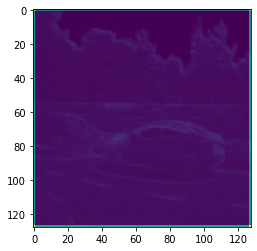

In [19]:
# 第二层卷积输出特征图
# conv2_transpose = tf.transpose(h_conv2, [3, 0, 1, 2])
# fig3,ax3 = plt.subplots(nrows=4, ncols=8, figsize = (16, 8), sharex='col', sharey='row')
# for j in range(4):
#     for k in range(8):
#         i = j * 8 + k
#         ax3[j][k].imshow(conv2_transpose[i][0])
# plt.title('Conv2 32x256x256')
# plt.savefig('./output/tir-conv2.png', dpi=600)
# plt.show()

# 第二层池化后的特征图
pool2_transpose = tf.transpose(h_pool2, [3, 0, 1, 2])
conv2_feature = np.zeros(pool2_transpose[0][0].shape)
for i in range(32):
    conv2_feature += pool2_transpose[i][0]
conv2_feature /= 32
plt.imshow(conv2_feature)
# fig4,ax4 = plt.subplots(nrows=4, ncols=8, figsize = (16, 8), sharex='col', sharey='row')
# for j in range(4):
#     for k in range(8):
#         i = j * 8 + k
#         ax4[j][k].imshow(pool2_transpose[i][0])
# plt.title('Pool2 32x128x128')
# plt.savefig('./output/tir-pool2.png', dpi=600)
# plt.show()

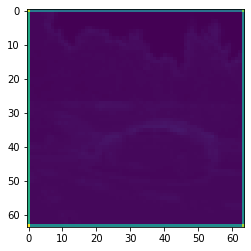

In [20]:
# 第三层卷积输出特征图
# conv3_transpose = tf.transpose(h_conv3, [3, 0, 1, 2])
# fig5,ax5 = plt.subplots(nrows=4, ncols=8, figsize = (16, 8), sharex='col', sharey='row')
# for j in range(4):
#     for k in range(8):
#         i = j * 8 + k
#         ax5[j][k].imshow(conv3_transpose[i][0])
# plt.title('Conv3 32x256x256')
# plt.savefig('./output/tir-conv3.png', dpi=600)
# plt.show()

# 第三层池化后的特征图
pool3_transpose = tf.transpose(h_pool3, [3, 0, 1, 2])
conv3_feature = np.zeros(pool3_transpose[0][0].shape)
for i in range(32):
    conv3_feature += pool3_transpose[i][0]
conv3_feature /= 32
plt.imshow(conv3_feature)
# fig6,ax6 = plt.subplots(nrows=4, ncols=8, figsize = (16, 8), sharex='col', sharey='row')
# for j in range(4):
#     for k in range(8):
#         i = j * 8 + k
#         ax6[j][k].imshow(pool3_transpose[i][0])
# plt.title('Pool3 32x128x128')
# plt.savefig('./output/tir-pool3.png', dpi=600)
# plt.show()

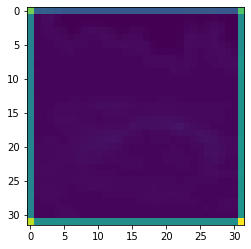

In [21]:
# 第四层卷积输出特征图
# conv4_transpose = tf.transpose(h_conv4, [3, 0, 1, 2])
# fig7,ax7 = plt.subplots(nrows=8, ncols=8, figsize = (16, 16), sharex='col', sharey='row')
# for j in range(8):
#     for k in range(8):
#         i = j * 8 + k
#         ax7[j][k].imshow(conv4_transpose[i][0])
# plt.title('Conv4 64x128x128')
# plt.savefig('./output/tir-conv4.png', dpi=600)
# plt.show()

# 第四层池化后的特征图
pool4_transpose = tf.transpose(h_pool4, [3, 0, 1, 2])
conv4_feature = np.zeros(pool4_transpose[0][0].shape)
for i in range(64):
    conv4_feature += pool4_transpose[i][0]
conv4_feature /= 64
plt.imshow(conv4_feature)
# fig8,ax8 = plt.subplots(nrows=8, ncols=8, figsize = (16, 16), sharex='col', sharey='row')
# for j in range(8):
#     for k in range(8):
#         i = j * 8 + k
#         ax8[j][k].imshow(pool4_transpose[i][0])
# plt.title('Pool4 64x64x64')
# plt.savefig('./output/tir-pool4.png', dpi=600)
# plt.show()

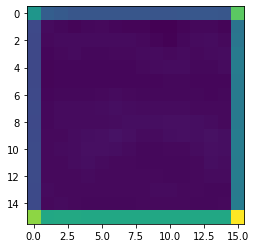

In [22]:
# 第五层卷积输出特征图
# conv5_transpose = tf.transpose(h_conv5, [3, 0, 1, 2])
# fig9,ax9 = plt.subplots(nrows=8, ncols=8, figsize = (16, 16), sharex='col', sharey='row')
# for j in range(8):
#     for k in range(8):
#         i = j * 8 + k
#         ax9[j][k].imshow(conv5_transpose[i][0])
# plt.title('Conv5 64x64x64')
# plt.savefig('./output/tir-conv5.png', dpi=600)
# plt.show()

# 第五层池化后的特征图
pool5_transpose = tf.transpose(h_pool5, [3, 0, 1, 2])
conv5_feature = np.zeros(pool5_transpose[0][0].shape)
for i in range(64):
    conv5_feature += pool5_transpose[i][0]
conv5_feature /= 64
plt.imshow(conv5_feature)
# fig0,ax0 = plt.subplots(nrows=8, ncols=8, figsize = (16, 16), sharex='col', sharey='row')
# for j in range(8):
#     for k in range(8):
#         i = j * 8 + k
#         ax0[j][k].imshow(pool5_transpose[i][0])
# plt.title('Pool5 64x32x32')
# plt.savefig('./output/tir-pool5.png', dpi=600)
# plt.show()